# Impedance Calibration Test Run

**Overview:**
1. Network Preparation
1. Import Matched Trace Data
2. Specify Calibration Parameters
    - Link Impedance Function
    - Turn Impedance Function
    - Objective/Loss Function
        - First Preference Recovery
        - Exact Overlap
        - Buffer Overlap (in development)
        - Frechet Distance/Area (in development)
3. Run Calibration
    - Particle Swarm Optimization (constrained & non-probabilistic)
    - Maximum likelihood estimation (unconstrained & probabilistic, in development)
1. Assess Results
    - Recalculate results for training set using best coefficients
    - Use best coefficients to calculate objective function for the test set
    - Compare against the shortest path results (with and without the elevation correction) using both training and testing sets
1. Look at where calibrated function did the best/worst job for both the training/testing set
1. Cluster/segment results based on loss function value?
4. Export for application in BikewaySim

In [1]:
from pathlib import Path
import time
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
import networkx as nx
from stochopy.optimize import minimize
import stochastic_optimization
from tqdm import tqdm
import similaritymeasures
import random

from shapely.ops import LineString, MultiLineString

import sys
sys.path.insert(0,str(Path.cwd().parent))
from network.src import modeling_turns
import speedfactor

In [2]:
import json
config = json.load((Path.cwd().parent / 'config.json').open('rb'))
calibration_fp = Path(config['project_directory']) / 'Calibration'
cycleatl_fp = Path(config['project_directory']) / 'CycleAtlanta'
matching_fp = Path(config['project_directory']) / 'Map_Matching'
network_fp = Path(config['project_directory']) / 'Network'
if calibration_fp.exists() == False:
    calibration_fp.mkdir()

# Network Preparation
- Determine which links should be included for routing
- Create directed edge dataframe
- Format edge and turn attribute variables
- Prepare dictionaries for quick edge attribute access

In [3]:
turns = pd.read_parquet(network_fp/'turns_df.parquet')
links = gpd.read_file(network_fp/'final_network.gpkg',layer='edges')

In [4]:
#dicts for referencing certain link attributes quickly
geo_dict = dict(zip(links['linkid'],links['geometry']))

## Define which links are permitted for routing

In [5]:
#add highway into turns (need this for later steps)
highway_dict = dict(zip(links['linkid'],links['link_type']))
turns['source_link_type'] = turns['source_linkid'].map(highway_dict)
turns['target_link_type'] = turns['target_linkid'].map(highway_dict)
del highway_dict

In [6]:
#remove these types of links from routing
link_types_allowed = ['bike','pedestrian','road']
links['link_type'].unique()
links = links[links['link_type'].isin(link_types_allowed)]
turns = turns[turns['source_link_type'].isin(link_types_allowed) & turns['target_link_type'].isin(link_types_allowed)]

## Major/minor road classification to create high traffic stress variable


In [7]:
major_road = ['primary','secondary']
major_road = major_road + [item + '_link' for item in major_road]
minor_road = ['tertiary','unclassified','residential','service','trunk','living_street']
major_road = major_road + [item + '_link' for item in minor_road]
links.loc[links['highway'].isin(major_road),'link_type_new'] = 'major_road'
links.loc[links['highway'].isin(minor_road),'link_type_new'] = 'minor_road'
links.loc[links['link_type_new'].isna(),'link_type_new'] = links.loc[links['link_type_new'].isna(),'link_type']

In [8]:
links['high_traffic_stress'] = links['link_type_new'] == 'major_road'

In [9]:
links['motorized'] = links['link_type_new'].isin(['major_road','minor_road'])

Format variables (in progress)
HERE variables have error because of the conflation process

In [10]:
# above_30 = links['speedlimit_range_mph'].isin(['31-40 MPH','41-54 MPH','55-64 MPH'])
# more_than_1_lpd = links['lanes_per_direction'].isin(['2-3','> 4'])
# no_bike_infra = links['bike_facility_type'].isna()
# links['NACTO'] = 1
# links.loc[(above_30 | more_than_1_lpd) & no_bike_infra,'NACTO'] = 0
# links_geo = links['linkid'].map(geo_dict)
# links.reset_index(drop=True,inplace=True)
# links = gpd.GeoDataFrame(links,geometry=links_geo,crs='epsg:2240')
# links[links['NACTO']==0].explore()

## Format turn variables
Only count left and right turns if going from one road to another road.

In [11]:
#sets turns that are not from road to road to None, effectively ignoring them
turns.loc[(turns['source_link_type']!='road') & (turns['target_link_type']!='road'),'turn_type'] = None

In [12]:
turns['left'] = turns['turn_type'] == 'left'
turns['right'] = turns['turn_type'] == 'right'

## Directed network

In [13]:
directed_links = pd.read_parquet(network_fp/'directed_edges.parquet')

In [14]:
link_cols_drop = ['facility_fwd','facility_rev','reverse_geometry','ascent_m', 'ascent_grade_%', 'descent_m', 'descent_grade_%']
links.drop(columns=link_cols_drop,inplace=True)

In [15]:
#add the appropriate directed columns (should only be one step)
directed_cols_to_add = ['linkid','reverse_link','facility_fwd','ascent_m','ascent_grade_%']
links = pd.merge(links,directed_links[directed_cols_to_add])
del directed_cols_to_add

### Remove wrongway

In [16]:
#add highway into turns (need this for later steps)
oneway_dict = dict(zip(links['linkid'],links['oneway']))
turns['source_oneway'] = turns['source_linkid'].map(oneway_dict)
turns['target_oneway'] = turns['target_linkid'].map(oneway_dict)
del oneway_dict

In [17]:
source_wrongway = ((turns['source_oneway'] == True) & (turns['source_reverse_link'] == True)) == False
target_wrongway = ((turns['target_oneway'] == True) & (turns['target_reverse_link'] == True)) == False
turns = turns[source_wrongway & target_wrongway]

In [18]:
#remove wrongway links
#TODO did we remove these in the export network step too?
links = links.loc[((links['oneway']==True) & (links['reverse_link']==True)) == False]#,'reverse_link'].value_counts()

In [19]:
#fill in missing NAs
links['ascent_grade_%'] = links['ascent_grade_%'].fillna(0)

In [20]:
#TODO remove negative values from grade %
links['ascent_grade_%'] = links['ascent_grade_%'].abs()

In [21]:
#add elevation adjusted travel times based on assumed speed on flat ground
speedfactor.calculate_adjusted_speed(links,9)

In [22]:
# if you use these, you'll just get the shortest path back everytime
links['test_column'] = 1
turns['test_column'] = 0

# Form the turn graph needed for routing from the turns dataframe

In [23]:
turn_G = modeling_turns.make_turn_graph(turns)

# Specify Link Impedance Functions

## BicyclingPlus Demo Impedance Functions

Turn + Stress Impedance

In [24]:
#TODO allow for certain impedance functions to be left out

In [25]:
#have position of beta next to name of variable
#NOTE: keys must be in the currect order used
betas_links = {
    0 : 'high_traffic_stress',
    1 : 'motorized'
    #1 : 'ascent_grade_%'
} 
betas_turns = {
    2 : 'left',
    3 : 'right',
    4 : 'signalized'
}

'''
Currently works with binary and numeric variables. Categorical data will have to be
cast into a different format for now.

Link impedance is weighted by the length of the link, turns are just the impedance associated
'''

#customize this function to change impedance formula
#TODO streamline process of trying out new impedance functions
def link_impedance_function(betas,beta_links,links,base_impedance_col):
    #prevent mutating the original links gdf
    links = links.copy()
    
    multiplier = np.zeros(links.shape[0])
    
    #assumes that these effects are additive
    for key, item in beta_links.items():
        multiplier = multiplier + (betas[key] * links[item].values)
    #final multplier is a proportion increase to the base impedance
    #ex: a value 0f 0.5 would mean a 50 increase to the link impedance
    links['link_cost'] = links[base_impedance_col] * (1+multiplier)

    return links

def turn_impedance_function(betas,beta_turns,turns):
    #use beta coefficient to calculate turn cost
    # base_turn_cost = 30 # from Lowry et al 2016 DOI: http://dx.doi.org/10.1016/j.tra.2016.02.003
    # turn_costs = {
    #     'left': betas[1] * base_turn_cost,
    #     'right': betas[1] * base_turn_cost,
    #     'straight': betas[1] * base_turn_cost
    # }
    #turns['turn_cost'] = turns['turn_type'].map(turn_costs)

    turns = turns.copy()

    turns['turn_cost'] = 0
    #instance impedance
    for key, item in beta_turns.items():
        turns['turn_cost'] = turns['turn_cost'] + (betas[key] * turns[item])

    #not sure if needed
    turns['turn_cost'] = turns['turn_cost'].astype(float)

    return turns

# Import Training Set

In [26]:
# gdf = train_set[random_trip]['matched_edges']
# gdf['geometry'] = gdf['linkid'].map(geo_dict)
# gdf = gpd.GeoDataFrame(gdf,crs=config['projected_crs_epsg'])
# gdf.explore()

# Calibration Settings

In [27]:
#TODO put the loss/objective functions in a class for documentation purposes

In [28]:
base_impedance_col = "travel_time_min"
loss_function = stochastic_optimization.jaccard_index
length_dict = dict(zip(links['linkid'],links['length_ft'])) # need this for loss function
loss_function_kwargs = {'length_dict':length_dict}#,'overlap_threshold':0.80}

# loss_function = stochastic_optimization.buffer_overlap
# loss_function_kwargs = {'geo_dict':geo_dict,'buffer_ft':100,'standardize':True}

# link coefficients control the % increase in link travel time (units don't matter)
# turn coefficients control the amount of seconds added from the turn (units matter)
link_bounds = [[0, 2] for _ in range(0, len(betas_links))]
turn_bounds = [[0, 2] for _ in range(0, len(betas_turns))]
bounds = np.vstack([link_bounds,turn_bounds])

In [29]:
with (calibration_fp/'test_set.pkl').open('rb') as fh:
    test_set = pickle.load(fh)
with (calibration_fp/'train_set.pkl').open('rb') as fh:
    train_set = pickle.load(fh)

# import random
# random_trip = 1797#random.choice(list(train_set.keys()))
# train_set = {random_trip:train_set[random_trip]}

# #match the ods to the network
# train_ods = stochastic_optimization.match_results_to_ods(train_set)
# test_ods = stochastic_optimization.match_results_to_ods(test_set)

In [ ]:
#takes about 14 hours for 500 trips

In [30]:
results = {}

for tripid, item in tqdm(train_set.items()):
    one_set = {tripid:item}
    one_ods = stochastic_optimization.match_results_to_ods(one_set)

    past_betas = []
    past_vals = []
    args = (
        past_betas,
        past_vals,
        betas_links,betas_turns,
        one_ods,one_set,
        link_impedance_function,
        base_impedance_col,
        turn_impedance_function,
        links,turns,turn_G,
        loss_function,
        loss_function_kwargs,
        False
    )

    start = time.time()
    # args = (df_edges,turns,turn_G,matched_traces,False)
    #print(list(betas_links.values())+list(betas_turns.values())+['objective_function'])
    x = minimize(stochastic_optimization.impedance_calibration, bounds, args=args, method='pso', options={'maxiter':5})
    end = time.time()
    #print(f'Took {(end-start)/60/60:.2f} hours')
    
    results[tripid] = {
        'betas': past_betas[np.array(past_vals).argmin()],
        'loss': np.array(past_vals).min().round(3)
    }

100%|██████████| 500/500 [14:11:35<00:00, 102.19s/it]  


In [68]:
loss = [tuple([key,item['loss'],*item['betas']]) for key, item in results.items()]
labels = ['tripid','Loss Function','High Traffic Stress', 'Motorized','Left Turn','Right Turn','Signalized']
loss = pd.DataFrame.from_records(loss,columns=labels)
#coef = [(key,key:item['betas'] for key, item in results.items()]
loss['Loss Function'] = loss['Loss Function'].abs()
loss.set_index('tripid',inplace=True)

In [69]:
#add trip info?


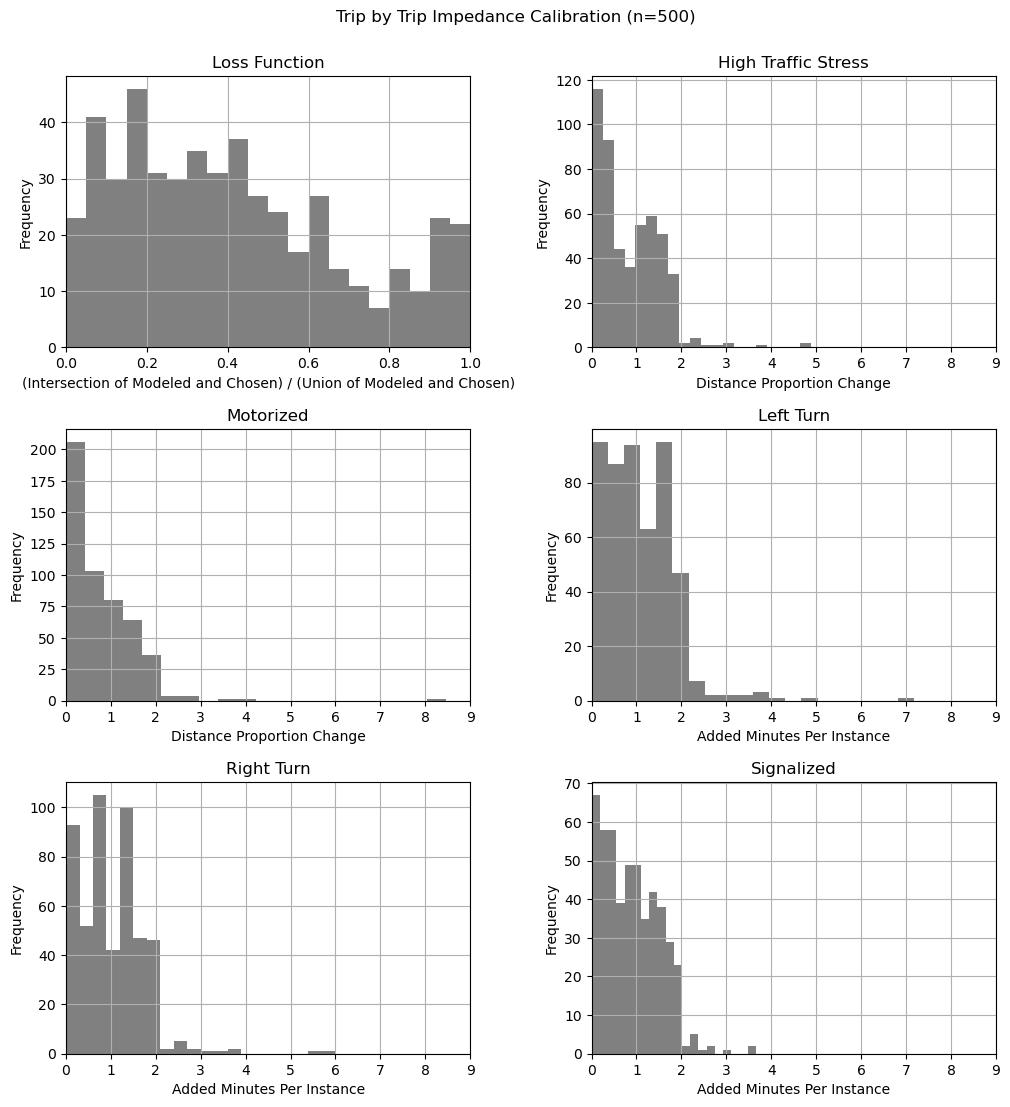

In [94]:
import matplotlib.pyplot as plt
ax = loss.hist(figsize=(12,12),bins=20,color='grey')

# Add a title for the entire figure
plt.suptitle('Trip by Trip Impedance Calibration (n=500)')
plt.subplots_adjust(top=0.925)

x_labels = ['(Intersection of Modeled and Chosen) / (Union of Modeled and Chosen)','Distance Proportion Change','Distance Proportion Change','Added Minutes Per Instance','Added Minutes Per Instance','Added Minutes Per Instance']
x_lims = [(0,1),(0,9),(0,9),(0,9),(0,9),(0,9)]
for i, sub_ax in enumerate(ax.flatten()):
    sub_ax.set_xlabel(x_labels[i])
    sub_ax.set_ylabel('Frequency')
    sub_ax.set_xlim(x_lims[i])

In [ ]:
loss = pd.DataFrame.from_dict(loss,orient='index')
coef = pd.DataFrame.from_dict(coef)
test.describe()

In [33]:
# with (calibration_fp/'imp_cal_ind.pkl').open('wb') as fh:
#     pickle.dump(results,fh)

# Shortest Path Comparison

In [31]:
# #shortest path results here for comparison
# stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)
# results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in train_ods}
# loss_values = loss_function(train_set,results_dict,**loss_function_kwargs)
# print(loss_values.mean().round(5))
# # 0.3102

In [32]:
# stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)
# results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in test_ods}
# loss_values = loss_function(test_set,results_dict,**loss_function_kwargs)
# print(loss_values.mean().round(5))
# # 0.3034

# Shortest Path with Elevation Adjustment
Redo these later because nothing seems to have changed

In [33]:
# #shortest path results here for comparison
# stochastic_optimization.back_to_base_impedance("adj_travel_time_min",links,turns,turn_G)
# results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in train_ods}
# loss_values = loss_function(train_set,results_dict,**loss_function_kwargs)
# print(loss_values.mean().round(5))
# # 0.31022

In [34]:
# stochastic_optimization.back_to_base_impedance("adj_travel_time_min",links,turns,turn_G)
# results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in test_ods}
# loss_values = loss_function(test_set,results_dict,**loss_function_kwargs)
# print(loss_values.mean().round(5))
# # 0.30337

# Impedance Calibration

In [35]:
# from importlib import reload
# reload(stochastic_optimization)

# start = time.time()
# # args = (df_edges,turns,turn_G,matched_traces,False)
# print(list(betas_links.values())+list(betas_turns.values())+['objective_function'])
# x = minimize(stochastic_optimization.impedance_calibration, bounds, args=args, method='pso', options={'maxiter':5})
# end = time.time()
# print(f'Took {(end-start)/60/60:.2f} hours')

['high_traffic_stress', 'motorized', 'left', 'right', 'signalized', 'objective_function']
[0.06, 1.42, 1.01, 1.64, 0.61, -0.4548]
[0.44, 0.45, 0.49, 0.89, 0.23, -0.227]
[1.07, 0.87, 0.82, 1.41, 0.44, -0.4548]
[0.29, 0.05, 1.47, 1.29, 1.82, -0.9111]
[1.83, 1.06, 0.26, 1.0, 1.09, -0.4535]
[0.88, 1.29, 1.64, 0.6, 0.89, -0.4548]
[0.63, 0.6, 1.26, 0.25, 1.68, -0.4535]
[1.22, 1.88, 1.85, 1.88, 0.03, -0.4548]
[1.65, 1.69, 0.09, 0.49, 1.24, -0.4572]
[1.44, 0.2, 0.67, 0.08, 1.4, -0.4341]
[0.09, 0.58, 1.63, 1.41, 2.17, -0.9111]
[0.06, 0.61, 2.05, 1.41, 2.82, -0.9111]
[0.52, 0.5, 1.92, 1.4, 3.58, -0.9111]
[0.32, 0.11, 1.58, 1.3, 3.81, -0.9111]
[0.48, 0.3, 0.5, 1.42, 4.16, -0.549]
[0.31, 0.73, 1.63, 0.92, 3.02, -0.9111]
[0.45, 0.75, 1.65, 0.43, 2.75, -0.4535]
[1.03, 0.99, 1.75, 0.51, 2.74, -0.4535]
[0.21, 1.15, 1.98, 0.95, 3.39, -0.4549]
[1.14, 0.36, 1.1, 0.93, 2.17, -0.9111]
Took 0.02 hours


In [36]:
# # MLE version to try out
# # Optimization to find the optimal beta coefficients
# result = minimize(loss_function, initial_beta, args=(G, observed_paths), method='BFGS')
# optimal_beta = result.x

# print(f"Optimal coefficients: {optimal_beta.round(2)}")

In [37]:
x

     fun: -0.9110820133596826
 message: 'best solution value is lower than ftol'
    nfev: 20
     nit: 2
  status: 1
 success: True
       x: array([1.13728174, 0.36388222, 1.09654613, 0.92942665, 2.17403787])

In [38]:
print('high stress,','ascent grade %,','left,','right,','signalized,','val')
print(past_betas[np.array(past_vals).argmin()],np.array(past_vals).min().round(3))

high stress, ascent grade %, left, right, signalized, val
(0.2894069234433818, 0.05242400941524694, 1.4676831442586866, 1.2906367361172162, 1.8165218047435987) -0.911


Create GIFs

In [39]:
import geopandas as gpd
import matplotlib.pyplot as plt
import imageio
from io import BytesIO

# Function to plot a GeoSeries and save the plot
def plot_geoseries(geoseries,other_geoseries,i,past_val):
    fig, ax = plt.subplots(figsize=(20, 20))
    #cx.add_basemap(ax)
    other_geoseries.plot(ax=ax,color='blue',style_kwds={'linewidth':2})
    geoseries.plot(ax=ax,color='red')
    ax.set_title(f"Iter:{i} Overlap Function:{past_val}")
    ax.set_axis_off()
    img_bytes = BytesIO()
    plt.savefig(img_bytes, format='png', bbox_inches='tight')
    plt.close()
    return img_bytes.getvalue()

In [40]:
# num_trips = 10

# for z in range(0,num_trips):

#     #choose a random tripid
#     tripid = random.choice(list(train_set.keys()))
#     start_node = train_set[tripid]['start_node']
#     end_node = train_set[tripid]['end_node']

#     matched_edges = train_set[tripid]['matched_edges']
#     matched_edges = np.array(matched_edges)
#     matched_line = MultiLineString([geo_dict[linkid] for linkid, reverse_link in matched_edges])
#     matched_line = gpd.GeoSeries(matched_line,crs='epsg:2240')
#     matched_line = matched_line.to_crs('epsg:4326')

#     modeled_lines = []

#     for betas in past_betas:
#         #update network with the correct impedances
#         stochastic_optimization.impedance_update(betas,betas_links,betas_turns,
#                                 link_impedance_function,
#                                 turn_impedance_function,
#                                 links,turns,turn_G)
#         #find shortest path
#         modeled_edges = stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node)['edge_list']
#         modeled_line = MultiLineString([geo_dict[linkid] for linkid, reverse_link in modeled_edges])
#         modeled_line = gpd.GeoSeries(modeled_line,crs='epsg:2240')
#         modeled_line = modeled_line.to_crs('epsg:4326')
#         modeled_lines.append(modeled_line)

#     # List of GeoSeries (Replace this with your own GeoSeries list)
#     geoseries_list = modeled_lines

#     # Loop through the list of GeoSeries, plot each one, and save the plot
#     images = []
#     for i, geoseries in enumerate(geoseries_list):
#         past_val = past_vals[i]
#         image_bytes = plot_geoseries(geoseries,matched_line,i,past_val)
#         images.append(imageio.imread(BytesIO(image_bytes)))

#     # Path for saving the GIF
#     gif_path = f"animations/stress_animation_{z}.gif"

#     # Save the images as a GIF
#     imageio.mimsave(Path.cwd()/gif_path, images, format='gif', duration=2)


# Validation

In [41]:
from importlib import reload
reload(stochastic_optimization)

<module 'stochastic_optimization' from 'c:\\Users\\tpassmore6\\Documents\\GitHub\\BikewaySimDev\\impedance_calibration\\stochastic_optimization.py'>

In [42]:
# #link_impedance_col = "adj_travel_time_min"
# stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)

# #update impedances
# betas = past_betas[np.array(past_vals).argmin()]#x.x
# print(betas)
# stochastic_optimization.impedance_update(betas,betas_links,betas_turns,
#                           link_impedance_function,
#                           base_impedance_col,
#                           turn_impedance_function,
#                           links,turns,turn_G)

# #find shortest path
# results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in test_ods}

# #calulate objective function
# val_to_minimize = loss_function(test_set,results_dict,**loss_function_kwargs)
# val_to_minimize.mean().round(2)

In [45]:
#link_impedance_col = "adj_travel_time_min"
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)

#update impedances
betas = past_betas[np.array(past_vals).argmin()]#x.x
print(betas)
stochastic_optimization.impedance_update(betas,betas_links,betas_turns,
                          link_impedance_function,
                          base_impedance_col,
                          turn_impedance_function,
                          links,turns,turn_G)

#find shortest path
results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in train_ods}

#calulate objective function
val_to_minimize = loss_function(train_set,results_dict,**loss_function_kwargs)
val_to_minimize.mean().round(2)

(0.2894069234433818, 0.05242400941524694, 1.4676831442586866, 1.2906367361172162, 1.8165218047435987)


0.91

## Visualize random trip

These did well

In [46]:
fpr_results = stochastic_optimization.first_preference_recovery(train_set,results_dict,**{'length_dict':length_dict,'overlap_threshold':0.7})
fpr_results

array([1797])

In [47]:
import random
tripid = random.choice(fpr_results)
tripid
#retrieve chosen path linkids and convert them to tuple
chosen = [tuple(row) for row in train_set[tripid]['matched_edges'].to_numpy()]
shortest = [tuple(row) for row in train_set[tripid]['shortest_edges'].to_numpy()]

#retrieve modeled path linkids
start_node = train_set[tripid]['origin_node']
end_node = train_set[tripid]['destination_node']
modeled_edges = results_dict[(start_node,end_node)]['edge_list']

#get geos (non-directional)
chosen_geo = [geo_dict[linkid[0]] for linkid in chosen]
shortest_geo = [geo_dict[linkid[0]] for linkid in shortest]
modeled_geo = [geo_dict[linkid[0]] for linkid in modeled_edges]

chosen_lines = gpd.GeoSeries(chosen_geo,crs='epsg:2240')
shortest_lines = gpd.GeoSeries(shortest_geo,crs='epsg:2240')
modeled_lines = gpd.GeoSeries(modeled_geo,crs='epsg:2240')

stochastic_optimization.visualize_three_no_legend(chosen_lines,shortest_lines,modeled_lines)

and these not so much

In [ ]:
import random
not_good = list(set(test_set.keys()) - set(fpr_results))

In [ ]:
tripid = random.choice(not_good)
tripid
#retrieve chosen path linkids and convert them to tuple
chosen = [tuple(row) for row in test_set[tripid]['matched_edges'].to_numpy()]
shortest = [tuple(row) for row in test_set[tripid]['shortest_edges'].to_numpy()]

#retrieve modeled path linkids
start_node = test_set[tripid]['origin_node']
end_node = test_set[tripid]['destination_node']
modeled_edges = results_dict[(start_node,end_node)]['edge_list']

#get geos (non-directional)
chosen_geo = [geo_dict[linkid[0]] for linkid in chosen]
shortest_geo = [geo_dict[linkid[0]] for linkid in shortest]
modeled_geo = [geo_dict[linkid[0]] for linkid in modeled_edges]

chosen_lines = gpd.GeoSeries(chosen_geo,crs='epsg:2240')
shortest_lines = gpd.GeoSeries(shortest_geo,crs='epsg:2240')
modeled_lines = gpd.GeoSeries(modeled_geo,crs='epsg:2240')

stochastic_optimization.visualize_three_no_legend(chosen_lines,shortest_lines,modeled_lines)